<a href="https://colab.research.google.com/github/Thejasvenan/EN3150_A03_Vision/blob/main/PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:

import os
import random
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical

In [14]:

# Set seed for reproducibility

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [15]:
import kagglehub

# Download latest dataset
path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")
print("Path to dataset files:", path)

# Dataset root folder
updated_path = os.path.join(path, 'rice_leaf_diseases')
print(os.listdir(updated_path))

# Class folders
Leaf_smut = os.path.join(updated_path, 'Leaf smut')
leaf_blight = os.path.join(updated_path, 'Bacterial leaf blight')
Brown_spot = os.path.join(updated_path, 'Brown spot')

# Check sample files
print("Leaf smut files:", os.listdir(Leaf_smut)[:5])
print("Leaf blight files:", os.listdir(leaf_blight)[:5])
print("Brown spot files:", os.listdir(Brown_spot)[:5])

Using Colab cache for faster access to the 'rice-leaf-diseases' dataset.
Path to dataset files: /kaggle/input/rice-leaf-diseases
['Brown spot', 'Bacterial leaf blight', 'Leaf smut']
Leaf smut files: ['DSC_0330.jpg', 'DSC_0313.JPG', 'DSC_0515.jpg', 'DSC_0315.jpg', 'DSC_0338.JPG']
Leaf blight files: ['DSC_0372.JPG', 'DSC_0374.JPG', 'DSC_0398.JPG', 'DSC_0396.JPG', 'DSC_0370.jpg']
Brown spot files: ['DSC_0305.JPG', 'DSC_0394.jpg', 'DSC_0105.jpg', 'DSC_0104.jpg', 'DSC_0325.JPG']


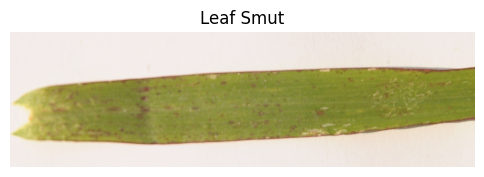

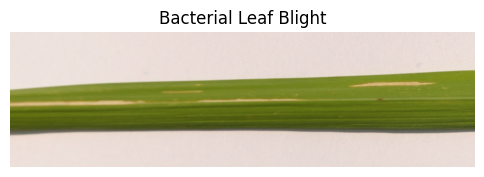

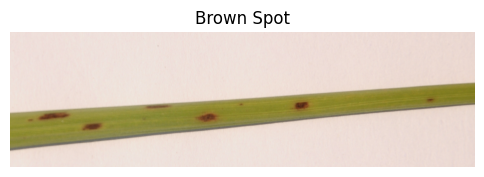

In [29]:

i = 20

Leaf_smut_1 = Image.open(os.path.join(Leaf_smut, os.listdir(Leaf_smut)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Leaf_smut_1)
plt.axis('off')
plt.title("Leaf Smut")
plt.show()

leaf_blight_1 = Image.open(os.path.join(leaf_blight, os.listdir(leaf_blight)[i]))
plt.figure(figsize=(6,6))
plt.imshow(leaf_blight_1)
plt.axis('off')
plt.title("Bacterial Leaf Blight")
plt.show()

Brown_spot_1 = Image.open(os.path.join(Brown_spot, os.listdir(Brown_spot)[i]))
plt.figure(figsize=(6,6))
plt.imshow(Brown_spot_1)
plt.axis('off')
plt.title("Brown Spot")
plt.show()

In [17]:
# Split dataset into train/val/test directories

output_base = "dataset_split"

for folder in ["train", "val", "test"]:
    for cls in ["Leaf smut", "Bacterial leaf blight", "Brown spot"]:
        os.makedirs(os.path.join(output_base, folder, cls), exist_ok=True)

# Function to copy files
def split_and_copy(class_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    files = os.listdir(class_folder)
    random.shuffle(files)
    n = len(files)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)

    for f in files[:n_train]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "train", class_name, f))
    for f in files[n_train:n_train+n_val]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "val", class_name, f))
    for f in files[n_train+n_val:]:
        shutil.copy(os.path.join(class_folder, f), os.path.join(output_base, "test", class_name, f))

# Split each class
split_and_copy(Leaf_smut, "Leaf smut")
split_and_copy(leaf_blight, "Bacterial leaf blight")
split_and_copy(Brown_spot, "Brown spot")


In [18]:

IMG_SIZE = (128, 128)
BATCH_SIZE = 10

In [19]:

# Training augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Validation & test
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_base, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(output_base, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 105 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Found 33 images belonging to 3 classes.


In [25]:

# Build CNN Model
def build_simple_cnn(input_shape=(128,128,3), num_classes=3, dropout_rate=0.3):
    model = models.Sequential()
    # Conv block 1
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    # Conv block 2
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    # Conv block 3
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    # Flatten & Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = build_simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=3, dropout_rate=0.3)
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,307,395 (16.43 MB)

 Trainable params: 4,307,395 (16.43 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:

adam_epochs = 20

# First, Adam
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_adam = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=adam_epochs
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 921ms/step - accuracy: 0.3479 - loss: 1.1618 - val_accuracy: 0.3438 - val_loss: 1.1061
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 880ms/step - accuracy: 0.3347 - loss: 1.0976 - val_accuracy: 0.3438 - val_loss: 1.0815
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 842ms/step - accuracy: 0.3854 - loss: 1.0857 - val_accuracy: 0.4375 - val_loss: 1.0657
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 811ms/step - accuracy: 0.2706 - loss: 1.0877 - val_accuracy: 0.4688 - val_loss: 1.0508
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 876ms/step - accuracy: 0.4357 - loss: 1.0523 - val_accuracy: 0.5625 - val_loss: 1.0056
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 903ms/step - accuracy: 0.4520 - loss: 1.0497 - val_accuracy: 0.5312 - val_loss: 0.9688
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 730ms/step - accuracy: 0.4500 - loss: 1.0271 - val_accuracy: 0.5312 - val_loss: 0.9074
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 845ms/step - accuracy: 0.4021 - loss: 1.0100 - val_accurac

In [22]:

'''total_epochs = 40
sgd_epochs = 5
adam_epochs = total_epochs - sgd_epochs

# First, Adam
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_adam = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=adam_epochs
)

# Then, SGD
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=sgd_epochs
)'''


"total_epochs = 40\nsgd_epochs = 5\nadam_epochs = total_epochs - sgd_epochs\n\n# First, Adam\nmodel.compile(optimizer=optimizers.Adam(learning_rate=0.0001),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\nhistory_adam = model.fit(\n    train_generator,\n    validation_data=val_generator,\n    epochs=adam_epochs\n)\n\n# Then, SGD\nmodel.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\nhistory_sgd = model.fit(\n    train_generator,\n    validation_data=val_generator,\n    epochs=sgd_epochs\n)"

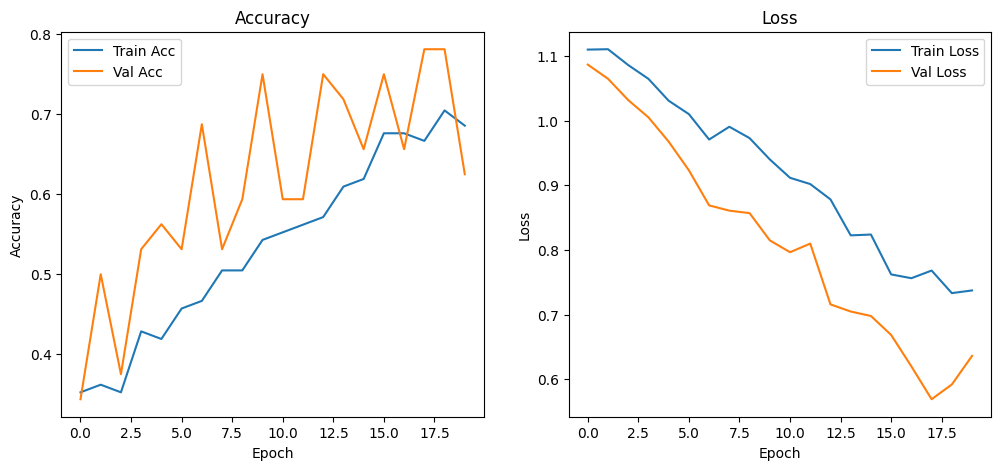

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_adam.history['accuracy'], label='Train Acc')
plt.plot(history_adam.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_adam.history['loss'], label='Train Loss')
plt.plot(history_adam.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8872 - loss: 0.3820
Test Accuracy: 69.70%
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


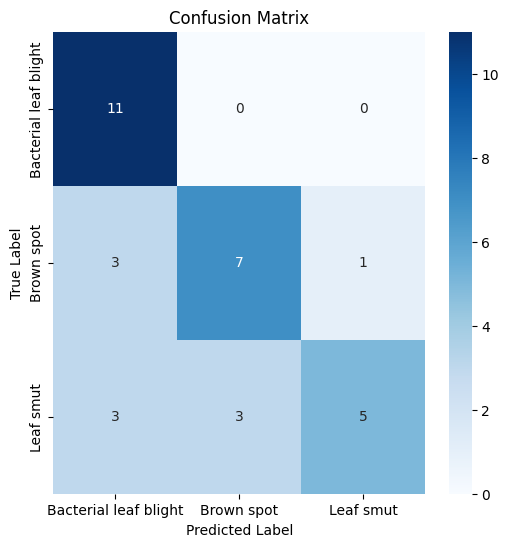

                       precision    recall  f1-score   support

Bacterial leaf blight       0.65      1.00      0.79        11
           Brown spot       0.70      0.64      0.67        11
            Leaf smut       0.83      0.45      0.59        11

             accuracy                           0.70        33
            macro avg       0.73      0.70      0.68        33
         weighted avg       0.73      0.70      0.68        33



In [23]:

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))